In [1]:
import numpy as np
import scipy.io
import pandas as pd
import pickle
from itertools import product
from typing import *
import os
from pathlib import Path
from tqdm import tqdm
from matplotlib import pyplot as plt
from fastplotlib import Plot
import seaborn as sns

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
torch.manual_seed(3141)

In [4]:
from scipy.io import loadmat

m = loadmat("/home/kushalk/repos/rnn-go-brr/rnngobrr/yuechen_data.mat")
m.keys()

dict_keys(['__header__', '__version__', '__globals__', 'all_directions_v2', 'direction_YQ1', 'realigned_traj_v2', 'traj_YQ1'])

In [5]:
directions = m["direction_YQ1"].flatten() - 1
np.unique(directions)
directions

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1], dtype=uint8)

In [6]:
a = m['traj_YQ1']

traj_origin = (a.T - a[:, :, 0].T).T

In [7]:
traj_origin.shape

(156, 3, 151)

In [8]:
traj = np.zeros((traj_origin.shape[0], traj_origin.shape[1] + 1, traj_origin.shape[2]-1))
traj[:, :3, :] = traj_origin[:, :, 1:]
traj[:, -1, :] = directions.reshape(-1, 1)

### `[n_trials, x-y-z-target_direction, n_timepoints]`

In [9]:
inputs = dict()
targets = dict()
for i, d in zip(range(3), ["x", "y", "z"]):
    inputs[d] = torch.tensor(traj[:, i, 0], dtype=torch.float32)
    targets[d] = torch.tensor(traj[:, i, :], dtype=torch.float32)

all_inputs = torch.tensor(traj[:, :, 0], dtype=torch.float32)
all_targets = torch.tensor(traj[:, :, :], dtype=torch.float32)

In [10]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
        )

        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_prev):
        rnn_out, hidden_prev = self.rnn(x, hidden_prev)
        out = self.linear(rnn_out)
        out = out.unsqueeze(dim=0)
        return out, hidden_prev, rnn_out

In [43]:
simple_rnn

SimpleRNN(
  (rnn): RNN(4, 500, batch_first=True)
  (linear): Linear(in_features=500, out_features=3, bias=True)
)

In [11]:
class AscentFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return input

    @staticmethod
    def backward(ctx, grad_input):
        return -grad_input


def make_ascent(loss):
    return AscentFunction.apply(loss)

In [12]:
def train(
    model: SimpleRNN,
    targets: torch.Tensor,
    optimizer: optim.Optimizer,
    lr0: int,
    loss_func: callable,
    n_epochs: int,
    gradient_ascent: bool = False
) -> SimpleRNN:
    """
    Parameters
    ----------

    SimpleRNN model instance

    `all_targets` created above

    optimizer, Adam seems to work well
    
    lr0, initial learning rate

    loss function, just MSE for now
    
    Returns
    -------
    
    SimpleRNN model instance, losses
    """

    losses = list()
    hidden_prev = torch.zeros(1, 156, model.hidden_size).cuda()

    for n_epoch in tqdm(range(n_epochs)):
        # give position and target direction [x, y, z, direction] of only first index!
        x = all_targets.swapaxes(1, 2)[:, 0, :].reshape(156, 1, 4) # [n_trajs, 1, (x0, y0, z0, dir_0)]
        y = all_targets.swapaxes(1, 2)[:, :, :3]

        output, hidden_prev, rnn_out = model(x.cuda(), hidden_prev)
        hidden_prev = hidden_prev.detach()
        
        if not gradient_ascent:
            loss = loss_func(output, y.cuda())
        else:
            loss = make_ascent(loss_func(output, y.cuda()))
        
        model.zero_grad()
        loss.backward()
        optimizer.step()
        
        # reduces learnign rate every 250 epochs, this helps A LOT
        if n_epoch % 250 == 0:
            lr0 = lr0 / 10
            for g in optimizer.param_groups:
                g['lr'] = lr0

        losses.append(loss.detach().cpu().numpy().item())
    
    return model, losses, rnn_out

In [13]:
simple_rnn = SimpleRNN(
    input_size=4,
    hidden_size=500,
    output_size=3,
).cuda()

In [14]:
lr = 0.001

simple_rnn, ls, rnn_out = train(
    model=simple_rnn,
    targets=all_targets,
    optimizer=optim.Adam(simple_rnn.parameters(), lr),
    lr0=lr,
    loss_func=nn.MSELoss(),
    n_epochs=3000
)

  0%|                                                                                      | 0/3000 [00:00<?, ?it/s]/home/clewis7/venvs/stor566/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([156, 150, 3])) that is different to the input size (torch.Size([1, 156, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████████████████████████████████████████████████████████████████████| 3000/3000 [00:04<00:00, 716.81it/s]


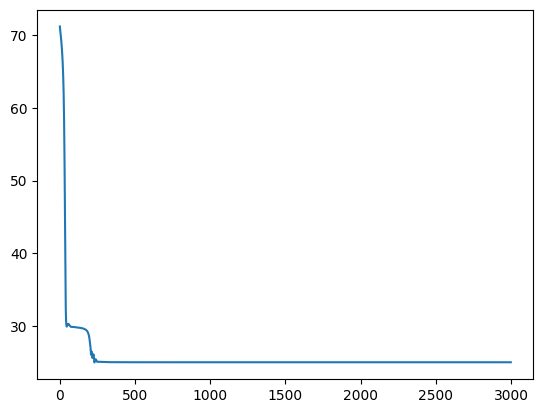

In [15]:
%matplotlib inline
plt.plot(ls)
plt.show()

In [16]:
ls[-10:]

[25.006290435791016,
 25.006296157836914,
 25.00629234313965,
 25.006290435791016,
 25.006290435791016,
 25.006296157836914,
 25.00629234313965,
 25.006296157836914,
 25.006284713745117,
 25.006288528442383]

In [17]:
def plot_preds(model, inputs):
    cmap = {
        0: "r",
        1: "b"
    }
    
    ax = plt.figure().add_subplot(projection='3d')
    
    all_preds = list()

    for ix_plot in tqdm(range(156)): # 156 trajs
        preds = list()
        hidden_prev = torch.zeros(1, 156, model.hidden_size).cuda()
        for _ in range(150): # length of each traj is 150
            pred, hidden_prev, rnn_out_t = model(inputs.cuda(), hidden_prev.cuda())
            input_x = pred
            preds.append(pred[0, ix_plot, 0, :].detach().cpu().numpy())
        preds_3d = np.vstack(preds)
        all_preds.append(preds_3d)
        ax.plot(preds_3d[:, 0], preds_3d[:, 1], preds_3d[:, 2], color=cmap[directions[ix_plot]])
    plt.show()
    return all_preds

In [18]:
def neural_activity(model, inputs):
    all_activity = list()
    hidden_prev = torch.zeros(1, 156, model.hidden_size).cuda()
    for _ in range(150): # length of each traj is 150
        pred, hidden_prev, rnn_out_t = model(inputs.cuda(), hidden_prev.cuda())
        all_activity.append(rnn_out_t.detach().cpu().numpy())
    return all_activity

In [28]:
inputs = all_targets.swapaxes(1, 2)[:, 0, :].reshape(156, 1, 4)
activity = neural_activity(simple_rnn, inputs)

In [20]:
len(activity)

150

In [30]:
activity = np.hstack(activity)
activity.shape

(156, 150, 500)

In [25]:
from sklearn.decomposition import PCA

In [32]:
act = np.zeros(shape=(156*150, 500), dtype=activity.dtype)

for i in range(activity.shape[0]):
    act[i * 150:(i + 1) * 150, :] = activity[i, :, :]

In [35]:
activity100 = activity[:, :, 0:100]
activity100.shape

(156, 150, 100)

In [37]:
act100 = np.zeros(shape=(156*150, 100), dtype=activity.dtype)

for i in range(activity.shape[0]):
    act100[i * 150:(i + 1) * 150, :] = activity100[i, :, :]

<AxesSubplot:>

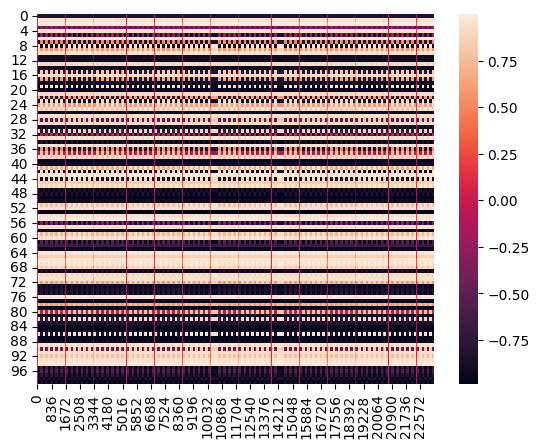

In [38]:
sns.heatmap(act100.T)

In [39]:
act100
pca = PCA(n_components=2)
transform = pca.fit_transform(act100)

In [41]:
act100.shape

(23400, 100)

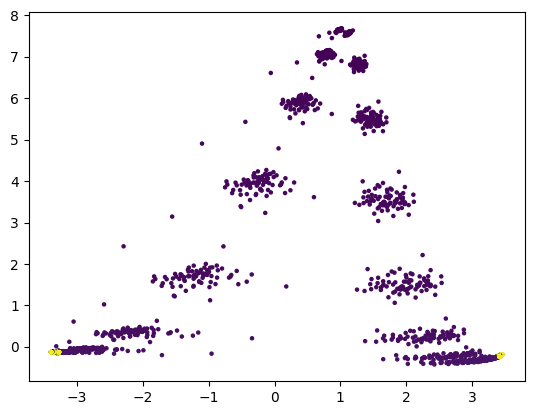

In [42]:
%matplotlib inline
for i in range(156):
    X_ = pca.transform(act100[i * 150:(i + 1) * 150, :])
    plt.scatter(X_[:, 0], X_[:, 1], s=5, c=np.arange(150), cmap="viridis")
plt.show()

<AxesSubplot:>

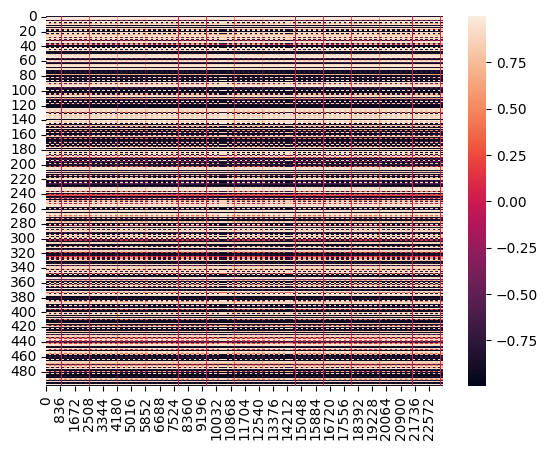

In [33]:
sns.heatmap(act.T)

In [ ]:
plt

In [56]:
act.shape

(23400, 1500)

In [59]:
pca = PCA(n_components=2)
transform = pca.fit_transform(act)

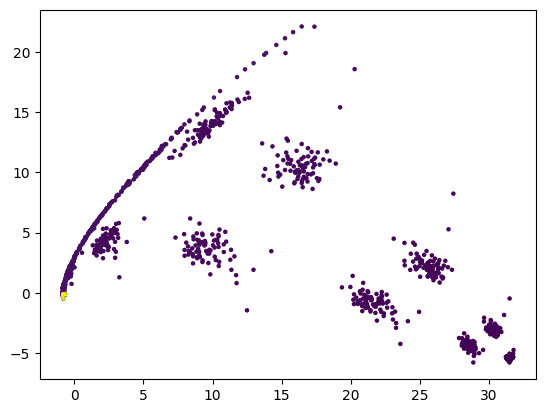

In [67]:
%matplotlib inline
for i in range(156):
    X_ = pca.transform(act[i * 150:(i + 1) * 150, :])
    plt.scatter(X_[:, 0], X_[:, 1], s=5, c=np.arange(150), cmap="viridis")
plt.show()

In [51]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(all_targets[:, :3, -1], directions)

def target_accuracy(predictions):
    return np.count_nonzero(
        log_reg.predict(
            np.vstack([p[-1] for p in predictions])
        ) == directions
    ) / directions.size

100%|█████████████████████████████████████████████████████████████████████████████| 156/156 [00:03<00:00, 40.36it/s]


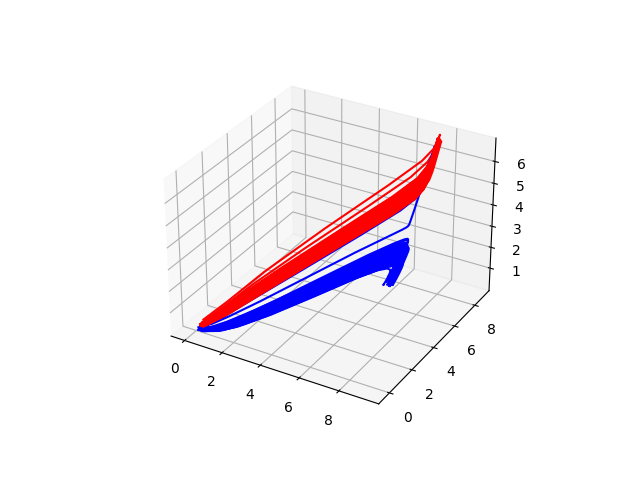

0.9871794871794872

In [54]:
%matplotlib ipympl
inputs = all_targets.swapaxes(1, 2)[:, 0, :].reshape(156, 1, 4)
preds = plot_preds(simple_rnn, inputs)
target_accuracy(preds)

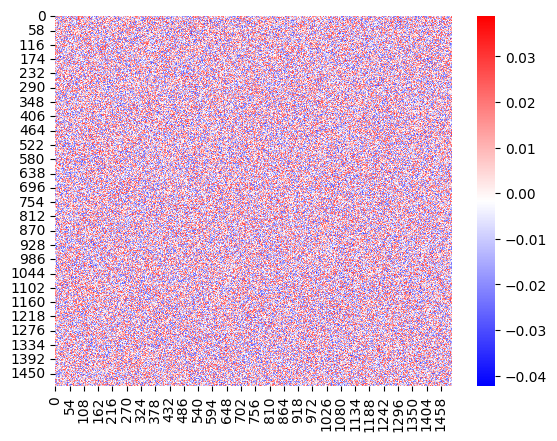

In [55]:
%matplotlib inline

sns.heatmap(simple_rnn.rnn.weight_hh_l0.detach().cpu().numpy(), cmap="bwr")
plt.show()

In [56]:
torch.save(simple_rnn.state_dict(), "./simple_rnn.pt")

In [68]:
prune_rnn = SimpleRNN(
    input_size=4,
    hidden_size=1500,
    output_size=3,
).cuda()

In [69]:
prune_rnn.load_state_dict(torch.load("./simple_rnn.pt"))

<All keys matched successfully>

In [70]:
(prune_rnn.rnn.weight_hh_l0.detach().cpu().numpy() == simple_rnn.rnn.weight_hh_l0.detach().cpu().numpy()).all()

True

In [71]:
import torch.nn.utils.prune as prune

In [72]:
n_prune = 400

class Pruner(prune.BasePruningMethod):
    PRUNING_TYPE = 'unstructured'

    def compute_mask(self, t, default_mask):
        mask = default_mask.clone()
        print(mask.shape)
        mask[:n_prune, n_prune:] = 0
        mask[n_prune:, :n_prune] = 0
        return mask

    
def pruner(module, name):
    Pruner.apply(module, name)
    return module

In [73]:
prune_rnn.rnn = pruner(prune_rnn.rnn, "weight_hh_l0")

torch.Size([1500, 1500])


Verifying the prunings

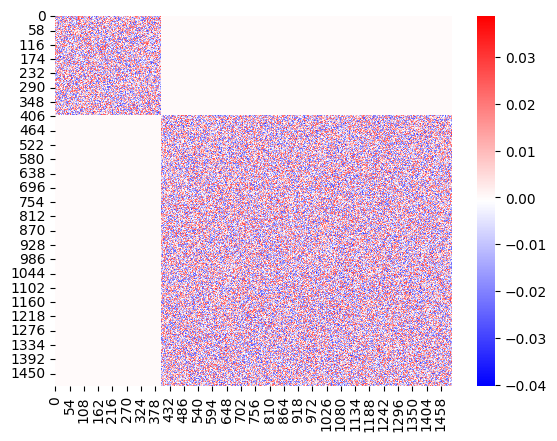

In [74]:
%matplotlib inline

sns.heatmap(prune_rnn.rnn.weight_hh_l0.detach().cpu().numpy(), cmap="bwr")
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████| 156/156 [00:05<00:00, 29.44it/s]


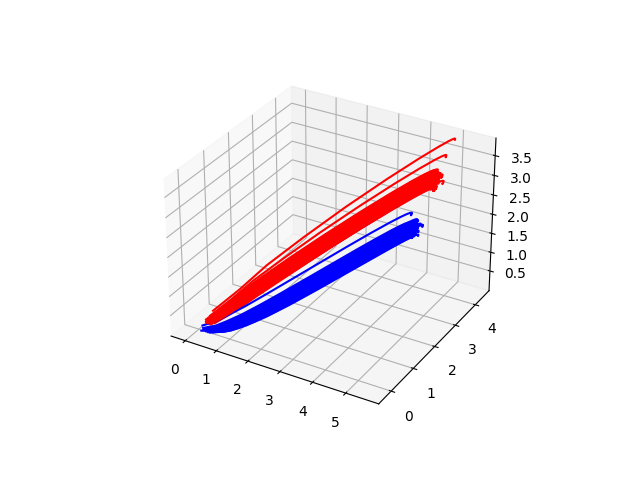

0.5128205128205128

In [75]:
%matplotlib ipympl
inputs = all_targets.swapaxes(1, 2)[:, 0, :].reshape(156, 1, 4)
preds = plot_preds(prune_rnn, inputs)
target_accuracy(preds)

In [76]:
lr = 0.001

prune_rnn, ls = train(
    model=prune_rnn,
    targets=all_targets,
    optimizer=optim.Adam(prune_rnn.parameters(), lr),
    lr0=lr,
    loss_func=nn.MSELoss(),
    n_epochs=20,
    gradient_ascent=True
)

  0%|                                                                                        | 0/20 [00:00<?, ?it/s]/home/clewis7/venvs/stor566/lib/python3.9/site-packages/torch/nn/modules/rnn.py:471: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.rnn_tanh(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/clewis7/venvs/stor566/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([156, 150, 3])) that is different to the input size (torch.Size([1, 156, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|███████████████████████████████████

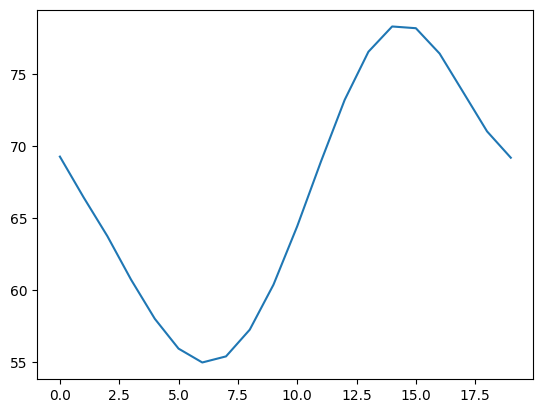

In [77]:
%matplotlib inline
plt.plot(ls)

In [78]:
lr = 0.001

prune_rnn, ls = train(
    model=prune_rnn,
    targets=all_targets,
    optimizer=optim.Adam(prune_rnn.parameters(), lr),
    lr0=lr,
    loss_func=nn.MSELoss(),
    n_epochs=1250,
    gradient_ascent=False
)

100%|██████████████████████████████████████████████████████████████████████████| 1250/1250 [00:01<00:00, 775.37it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 156/156 [00:05<00:00, 30.53it/s]


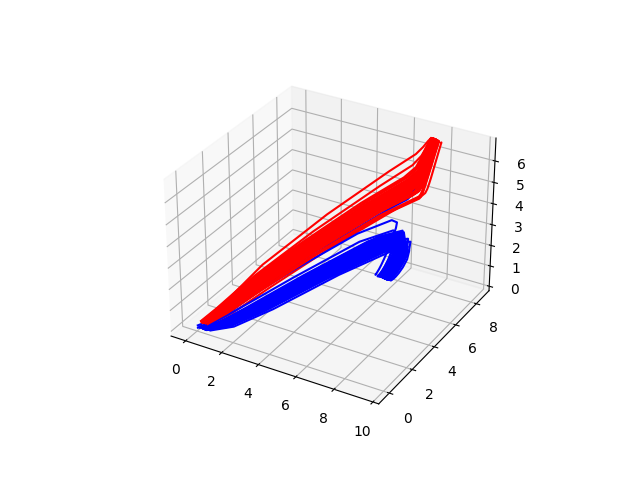

0.9935897435897436

In [79]:
%matplotlib ipympl
inputs = all_targets.swapaxes(1, 2)[:, 0, :].reshape(156, 1, 4)
preds = plot_preds(prune_rnn, inputs)
target_accuracy(preds)

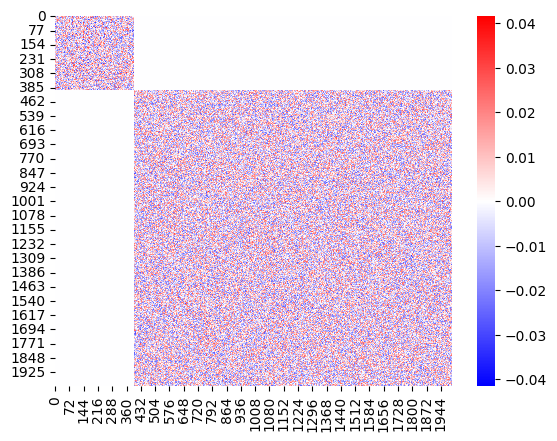

In [34]:
%matplotlib inline
sns.heatmap(prune_rnn.rnn.weight_hh_l0.detach().cpu().numpy(), cmap="bwr")
plt.show()